<a href="https://colab.research.google.com/github/Prasang-Biyani/DenseNet/blob/main/DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/CIFR

Mounted at /content/drive
/content/drive/MyDrive/CIFR


In [ ]:
%tensorflow_version 2.x
%load_ext tensorboard
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 4.3 MB/s 


In [ ]:
import os
import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, Concatenate, SeparableConv2D
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
import tensorflow_datasets.public_api as tfds
import pandas as pd
import numpy as np

In [ ]:
growth_rate = 12
compression = 0.5
BATCH_SIZE = 256
INIT_LR = 1e-2
MAX_LR = 9e-2

In [ ]:
# Load CIFAR10 Data

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, img_channel = X_train.shape[1], X_train.shape[2], X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10) 

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

170508288/170498071 [==============================] - 6s 0us/step


In [ ]:
def dense_block(input_layer, num_of_filters, reptitions):

  temp_layer = input_layer

  for _ in range(reptitions):
    bn = BatchNormalization()(temp_layer)
    ac = Activation(activation='relu')(bn)
    conv2d_1_1 = Conv2D(filters=int(2 * num_of_filters * compression), kernel_size=(1, 1), padding='same', use_bias=True)(ac)

    bn = BatchNormalization()(conv2d_1_1)
    ac = Activation(activation='relu')(bn)
    conv2d_3_3 = Conv2D(filters=int(num_of_filters * compression), kernel_size=(3, 3), padding='same', use_bias=True)(ac)

    concat = Concatenate(axis=-1)([temp_layer, conv2d_3_3])
    temp_layer = concat

  return temp_layer

def transition_layer(input_layer, num_of_filters):

  bn = BatchNormalization()(input_layer)
  ac = Activation(activation='relu')(bn)
  conv2d = Conv2D(filters=int(num_of_filters * compression), kernel_size=(1, 1), use_bias=True, padding='same')(ac)
  pooling = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(conv2d)

  return pooling

In [ ]:
from tensorflow.python.keras.backend import dtype
tf.keras.backend.clear_session()
# tf.keras.mixed_precision.set_global_policy("mixed_bfloat16")

# defining architecture
input_layer = keras.Input(shape=(img_height, img_width, img_channel,))

data_augmentation = tf.keras.Sequential([
  # layers.Resizing(height=224, width=224),
  layers.Rescaling(scale=1/255.),
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.3),
  layers.RandomZoom(height_factor=0.5),
])(input_layer)

conv2d_1 = Conv2D(filters=32, kernel_size=(7, 7), strides=(2, 2), use_bias=False, padding='same')(data_augmentation)
max_pool_1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(conv2d_1)

dense_block_1 = dense_block(conv2d_1, 32, 6)
transition_layer_1 = transition_layer(dense_block_1, 500)

dense_block_2 = dense_block(transition_layer_1, 32, 6)
transition_layer_2 = transition_layer(dense_block_2, 432)

dense_block_3 = dense_block(transition_layer_2, 32, 6)
transition_layer_3 = transition_layer(dense_block_3, 432)

dense_block_4 = dense_block(transition_layer_3, 32, 6)

bn = BatchNormalization()(dense_block_4)
ac = Activation(activation='relu')(bn)
average_pooling = layers.GlobalAveragePooling2D()(ac)
# average_pooling = AveragePooling2D(pool_size=(7, 7), padding='same')(ac)
flatten = Flatten()(average_pooling)
output = Dense(10, activation='softmax')(flatten)

model = Model([input_layer], [output])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 32, 32, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 32)   4704        ['sequential[0][0]']             
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                   

In [ ]:
def scheduler(epoch, lr):
  if (epoch + 1) % 5 == 0:
    return lr * 0.9
  elif lr >= 0.5:
    lr = 0.01
    return lr
  else:
    return lr

# https://www.tensorflow.org/addons/tutorials/optimizers_cyclicallearningrate
steps_per_epoch = X_train.shape[0] // 256
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch
)
model.compile(optimizer=keras.optimizers.SGD(learning_rate=clr, momentum=0.95, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
!rm -rf model_logs log.csv

tf.keras.backend.clear_session()
logdir = os.path.join("model_logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=0)
csv_logger = tf.keras.callbacks.CSVLogger('log.csv', append=True)
learning_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.8,
                              patience=3, min_lr=0.001, min_delta=0.01)

model.fit(train_ds, epochs=300, validation_data=(test_ds), callbacks=[tensorboard_callback, csv_logger])

Epoch 1/300
196/196 [==============================] - 11s 36ms/step - loss: 1.8421 - accuracy: 0.3267 - val_loss: 2.2781 - val_accuracy: 0.2153
Epoch 2/300
196/196 [==============================] - 6s 32ms/step - loss: 1.6586 - accuracy: 0.3985 - val_loss: 2.0775 - val_accuracy: 0.2758
Epoch 3/300
196/196 [==============================] - 6s 32ms/step - loss: 1.5116 - accuracy: 0.4553 - val_loss: 1.7982 - val_accuracy: 0.3953
Epoch 4/300
196/196 [==============================] - 6s 32ms/step - loss: 1.3865 - accuracy: 0.5028 - val_loss: 1.3850 - val_accuracy: 0.5121
Epoch 5/300
196/196 [==============================] - 6s 32ms/step - loss: 1.3107 - accuracy: 0.5322 - val_loss: 1.4975 - val_accuracy: 0.4610
Epoch 6/300
196/196 [==============================] - 6s 32ms/step - loss: 1.3129 - accuracy: 0.5327 - val_loss: 1.3922 - val_accuracy: 0.4975
Epoch 7/300
196/196 [==============================] - 6s 32ms/step - loss: 1.2790 - accuracy: 0.5420 - val_loss: 1.3794 - val_accuracy

# Using ImageDataGenerator for comparsion of results.

In [ ]:
# Load CIFAR10 Data

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, img_channel = X_train.shape[1], X_train.shape[2], X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [ ]:
compression = 0.5
BATCH_SIZE = 64
INIT_LR = 1e-2
MAX_LR = 9e-2

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    # featurewise_center=True,
    featurewise_std_normalization=True,
    rescale=1/255.0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zca_epsilon=1e-06
    # vertical_flip=True,
    )

datagen.fit(X_train)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:349: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


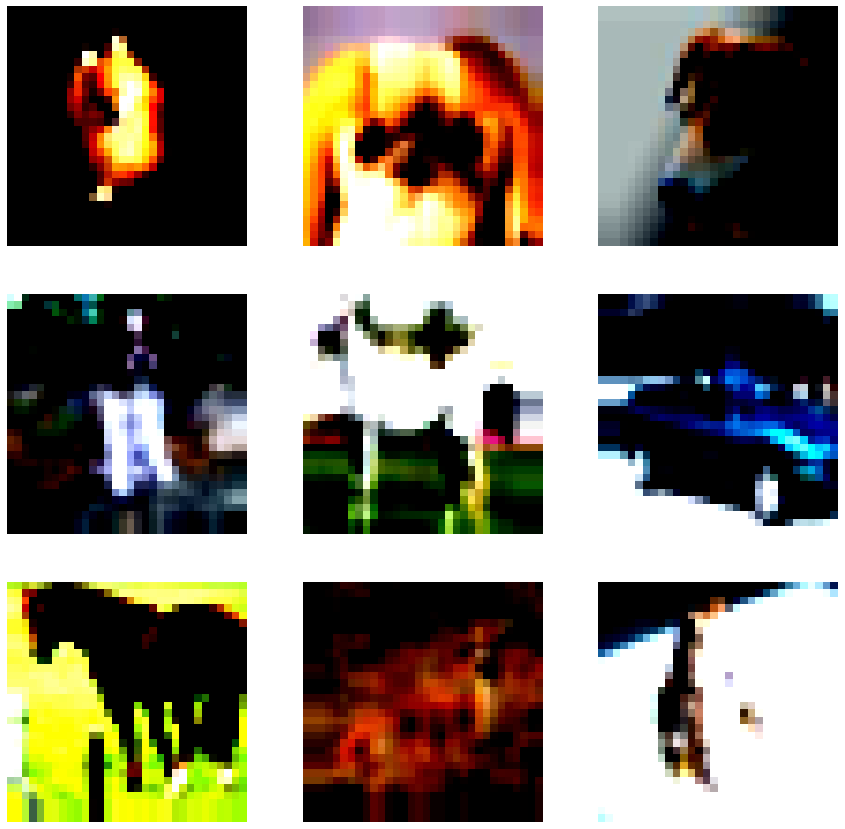

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

aug_iter = datagen.flow(X_train, batch_size=2)
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,15))
ax = ax.flatten()

# generate batch of images
for i in range(9):

	# convert to unsigned integers
	image = next(aug_iter)[0]
 
	# plot image
	ax[i].imshow(image)
	ax[i].axis('off')

In [ ]:
tf.keras.backend.clear_session()
# tf.keras.mixed_precision.set_global_policy("mixed_bfloat16")

# defining architecture
input_layer = keras.Input(shape=(img_height, img_width, img_channel,))
conv2d_1 = Conv2D(filters=42, kernel_size=(7, 7), use_bias=True, padding='same')(input_layer)
max_pool_1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(conv2d_1)

dense_block_1 = dense_block(conv2d_1, 42, 10)
transition_layer_1 = transition_layer(dense_block_1, 84)

dense_block_2 = dense_block(transition_layer_1, 42, 10)
transition_layer_2 = transition_layer(dense_block_2, 84)

dense_block_3 = dense_block(transition_layer_2, 42, 10)
transition_layer_3 = transition_layer(dense_block_3, 84)

dense_block_4 = dense_block(transition_layer_3, 42, 10)

bn = BatchNormalization()(dense_block_4)
ac = Activation(activation='relu')(bn)
average_pooling = layers.GlobalAveragePooling2D()(ac)
# average_pooling = AveragePooling2D(pool_size=(7, 7), padding='same')(ac)
flatten = Flatten()(average_pooling)
output = Dense(10, activation='softmax')(flatten)

model = Model([input_layer], [output])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 42)   6216        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 42)  168         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 42)   0           ['batch_normalization[0][0]']

In [ ]:
steps_per_epoch = X_train.shape[0] // 64
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch
)

def scheduler(epoch, lr):
  if (epoch + 1) % 10 == 0:
    return lr * 0.8
  # elif lr >= 0.5:
  #   lr = 0.01
  #   return lr
  else:
    return lr


model.compile(optimizer=keras.optimizers.SGD(learning_rate=clr, momentum=0.95), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
!rm -rf model_logs_image_data_generator/ log_image_data_generator.csv

logdir = os.path.join("model_logs_image_data_generator", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=0)
csv_logger = tf.keras.callbacks.CSVLogger('log_image_data_generator.csv', append=True)
learning_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.8,
                              patience=3, min_lr=0.001, min_delta=0.01)


model.fit(datagen.flow(X_train, y_train, batch_size=64),
         validation_data=datagen.flow(X_test, y_test,
         batch_size=64),
         epochs=300)

Epoch 1/300
782/782 [==============================] - 64s 71ms/step - loss: 1.6639 - accuracy: 0.3905 - val_loss: 1.8278 - val_accuracy: 0.4173
Epoch 2/300
782/782 [==============================] - 54s 69ms/step - loss: 1.1638 - accuracy: 0.5802 - val_loss: 1.9740 - val_accuracy: 0.4526
Epoch 3/300
782/782 [==============================] - 54s 69ms/step - loss: 0.8318 - accuracy: 0.7048 - val_loss: 1.0100 - val_accuracy: 0.6613
Epoch 4/300
782/782 [==============================] - 53s 68ms/step - loss: 0.6173 - accuracy: 0.7840 - val_loss: 0.5825 - val_accuracy: 0.7967
Epoch 5/300
782/782 [==============================] - 53s 67ms/step - loss: 0.5320 - accuracy: 0.8147 - val_loss: 0.6430 - val_accuracy: 0.7784
Epoch 6/300
782/782 [==============================] - 53s 68ms/step - loss: 0.5572 - accuracy: 0.8062 - val_loss: 1.2220 - val_accuracy: 0.6616
Epoch 7/300
782/782 [==============================] - 54s 69ms/step - loss: 0.5195 - accuracy: 0.8191 - val_loss: 0.5595 - val_ac

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model_one_text.png', show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None
)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.991377 to fit

